# Proccess ECM - Inncluding Opposite Face

The oposite face measuremetns were made well after the rest of the core. The true top depth of these measurements is unknown. Therefore, we'll have to apply shifts to make the ECM signal allign with the other faces

In [13]:
# general
import numpy as np
import pandas as pd
from tqdm import tqdm

# plotting
import matplotlib.pyplot as plt
from collections import OrderedDict 

# math
from scipy.stats import pearsonr


# my functions/classes
import sys
sys.path.append("../core_scripts/")
from ECMclass import ECM
from ECMclass import core_section


In [14]:
# Set filepaths

path_to_data = '../../data/'
path_to_figures = '../../../figures/'

In [15]:
angles = pd.read_csv(path_to_data + 'angles/angles.csv')
angles.head()

,core,section,ACorDC,top_angle,left_angle,right_angle,side_angle,true_dip,true_dip_angles,true_dip_scores
0,alhic1901,228_4,AC,-36.776051,16.199769,-10.606322,13.403045,-38.643013,[-38.87808981 -38.54424142 -39.18075393 -37.73...,[0.88933205 0.97882252 0.95474921 0.95895482 0...
1,alhic1901,230_4,AC,27.819776,30.749623,-30.156336,30.452979,38.799076,[36.94242001 34.92239342 34.74296877 37.507310...,[0.99150915 0.99005042 0.99079277 0.99085791 0...


In [ ]:
# Load metadata
meta = pd.read_csv(path_to_data + 'ecm/raw/metadata.csv')
meta.head()

# set smoothing window
window = 10

# Load ECM data
data = []
cores = []
sections = []
faces = []
ACorDCs = []
for index, row in tqdm(meta.iterrows(), total=len(meta), desc="Processing data"):
    
    core = row['core']
        
    section = row['section']
    face = row['face']
    ACorDC = row['ACorDC']

    if section == '228_4' and not face == 'o':
        print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)

        data_item = ECM(core,section,face,ACorDC,path_to_data + 'ecm/raw/')
        
        data_item.rem_ends(15)
        data_item.smooth(window)
        data.append(data_item)
        
        cores.append(core)
        sections.append(section)
        faces.append(face)
        ACorDCs.append(ACorDC)

    if section == '228_4' and face == 'o' and ACorDC == 'AC':
        print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)

        data_item = ECM(core,section,face,ACorDC,path_to_data + 'ecm/raw/')
        
        data_item.rem_ends(15)
        data_item.smooth(window)
        data.append(data_item)
        
        cores.append(core)
        sections.append(section)
        faces.append(face)
        ACorDCs.append(ACorDC)
    

# Put ECM data into core_section structure
s228_4_AC = core_section('228_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)
s228_4_DC = core_section('228_4','alhic1901','DC',data,sections,faces,cores,ACorDCs)

# place in 3D space
for s in [s228_4_AC,s228_4_DC]:
    s.add_3d_coords()

# mannually adjust the opposite face y-axis measurement (here it assumes 0)
for s in [s228_4_AC,s228_4_DC]:
    s.opposite.y_s = s.opposite.y_s - 10

Processing data:   0%|          | 0/14 [00:00<?, ?it/s]

Reading alhic1901, section 228_4-t-DC


Processing data:  21%|██▏       | 3/14 [00:00<00:00, 13.40it/s]

Reading alhic1901, section 228_4-l-AC


Processing data:  36%|███▌      | 5/14 [00:00<00:01,  8.63it/s]

Reading alhic1901, section 228_4-l-DC
Reading alhic1901, section 228_4-r-DC
Reading alhic1901, section 228_4-r-AC


Processing data:  79%|███████▊  | 11/14 [00:00<00:00, 14.09it/s]

Reading alhic1901, section 228_4-t-AC
Reading alhic1901, section 228_4-o-AC


Processing data:  93%|█████████▎| 13/14 [00:01<00:00,  6.23it/s]

Reading alhic1901, section 228_4-o-DC


Processing data: 100%|██████████| 14/14 [00:01<00:00,  7.13it/s]


In [17]:
# convert core class to df
ecm_data = pd.DataFrame()
for s in [s228_4_AC,s228_4_DC]:

    s_df = s.to_df()
    ecm_data = pd.concat([ecm_data,s_df],ignore_index=True)

In [18]:
# preform dip adjustment
def dip_adjust(angles,data):

    # Add 'top_angle' and 'side_angle' columns to data
    data['top_angle'] = data['section'].map(
        lambda sec: angles.loc[angles['section'] == sec, 'top_angle'].values[0]
    )
    data['side_angle'] = data['section'].map(
        lambda sec: angles.loc[angles['section'] == sec, 'side_angle'].values[0]
    )

    print("Mapped Angles")

    # make new depth columns
    data['top_depth_adj'] = data['top_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))
    print("Adjusted top depth")
    data['bottom_depth_adj'] = data['bottom_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))
    print("Adjusted bottom depth")
    data['mid_depth_adj'] = data['mid_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))
    print("Adjusted mid depth")

    return (data)

# preform dip adjustment
ecm_master = dip_adjust(angles,ecm_data)

# remove the 'top_angle' and 'side_angle' columns from the ecm_master dataframe
#ecm_master = ecm_master.drop(columns=['top_angle','side_angle','top_depth','mid_depth','bottom_depth'])

Mapped Angles
Adjusted top depth
Adjusted bottom depth
Adjusted mid depth


In [19]:
# simple before/after plot
def simple_plot(data,prox,path_to_figures,dtype,oneline=True):

    print("Oneline is " + str(oneline))

    # pull out unique values in data['section']
    sections = data['section'].unique()

    # make a set of colors for plot lines using colormap
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in range(len(data['stick'].unique()))]

    # make a plot for each core section
    for sec in sections:
        print("Plotting section " + str(sec))

        # filter for data in section
        df_sec = data.loc[data['section'] == sec]

        # new figure
        fig, ax = plt.subplots(len(prox), 2, figsize=(7, 2.5*len(prox)), dpi = 100, sharex=True)
        fig.suptitle('Section ' + str(sec))


        # new row for each proxy
        for i in range(len(prox)):
            print("    Plotting proxy " + prox[i])

            # filter for rows where this proxy does not contain NaN
            df_prox = df_sec.loc[~df_sec[prox[i]].isna()]

            # pull out data for this stick
            sticks = data['stick'].unique()

            # new line for each stick
            for j in range(len(sticks)):

                print("        Plotting stick " + str(sticks[j]))


                stick = sticks[j]

                # set label
                label = stick

                # pull out data for this stick
                df = df_prox.loc[df_sec['stick'] == stick]

                if len(df) == 0:
                    break
                
                if oneline:

                    # plot the data
                    ax[i,0].plot(
                        df['mid_depth'], 
                        df[prox[i]], 
                        color=colors[j],
                        label=label
                    )
                    ax[i,1].plot(
                        df['mid_depth_adj'], 
                        df[prox[i]], 
                        color=colors[j],
                        label=label
                    )

                    # for each data point, plot a line from 'top_depth' to 'bottom_depth' at the df[prox[i]] value
                    for k in range(len(df)):
                        ax[i,0].plot([df['top_depth'].iloc[k], df['bottom_depth'].iloc[k]], [df[prox[i]].iloc[k], df[prox[i]].iloc[k]], color=colors[j], alpha=0.5)
                        ax[i,1].plot([df['top_depth_adj'].iloc[k], df['bottom_depth_adj'].iloc[k]], [df[prox[i]].iloc[k], df[prox[i]].iloc[k]], color=colors[j], alpha=0.5)

                else:

                    # for each unique combination of effective_center_x and effective_center_y, plot a line
                    for x in df['effective_center_x'].unique():
                        for y in df['effective_center_y'].unique():

                            df_xy = df.loc[(df['effective_center_x'] == x) & (df['effective_center_y'] == y)]

                            if len(df_xy) == 0:
                                continue

                                                # plot the data

                            ax[i,0].plot(
                                df_xy['mid_depth'], 
                                df_xy[prox[i]], 
                                color=colors[j],
                                label=label
                            )
                            ax[i,1].plot(
                                df_xy['mid_depth_adj'], 
                                df_xy[prox[i]], 
                                color=colors[j],
                                label=label
                            )

                            label = '__nolegend__'

                # add labels
                ax[i,0].set_ylabel(prox[i])
                ax[i,1].set_ylabel(prox[i])
                ax[i,0].set_xlabel('Depth (m)')
                ax[i,1].set_xlabel('Depth (m)')
                ax[i,0].set_title(prox[i]+' - Before Dip Adjustment')
                ax[i,1].set_title(prox[i]+' - After Dip Adjustment')

                # add legend
                # handles, labels = ax.get_legend_handles_labels()
                # handle_list, label_list = [], []
                # for handle, label in zip(handles, labels):
                #     if label not in label_list:
                #         handle_list.append(handle)
                #         label_list.append(label)
                # plt.legend(handle_list, label_list)
                ax[i,0].legend(fontsize=8, loc='upper right')
                ax[i,1].legend(fontsize=8, loc='upper right')

        plt.tight_layout()
        fig.show()
        
        fig.savefig(path_to_figures + 'initial_dip_adjustment/' + dtype+'-'+ str(sec) + '.png', dpi=300)

Oneline is False
Plotting section 228_4
    Plotting proxy AC_ecm
        Plotting stick t
        Plotting stick l
        Plotting stick r
        Plotting stick o
    Plotting proxy DC_ecm
        Plotting stick t
        Plotting stick l
        Plotting stick r
        Plotting stick o


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_54751/1448958200.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


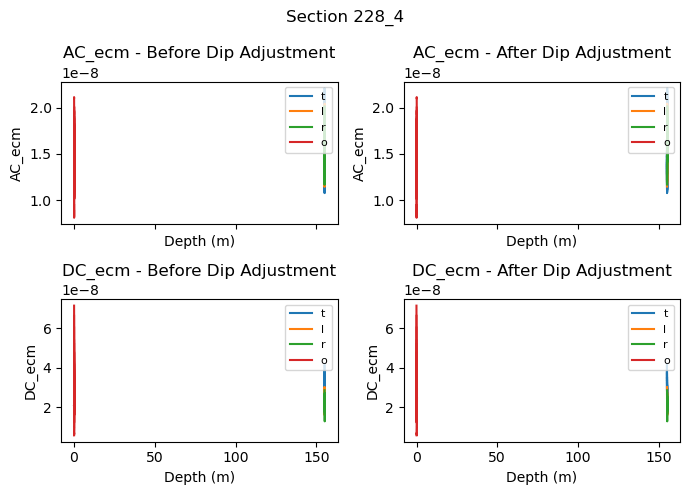

In [20]:
# Simple Plot
simple_plot(ecm_master,['AC_ecm','DC_ecm'],path_to_figures,'ECM',oneline=False)

In [21]:
ecm_master.columns

Index(['mid_depth', 'top_depth', 'bottom_depth', 'AC_ecm',
       'effective_center_x', 'effective_center_y', 'x_lo', 'x_hi', 'y_lo',
       'y_hi', 'section', 'stick', 'core', 'DC_ecm', 'top_angle', 'side_angle',
       'top_depth_adj', 'bottom_depth_adj', 'mid_depth_adj'],
      dtype='object')

In [22]:
ecm_master

,mid_depth,top_depth,bottom_depth,AC_ecm,effective_center_x,effective_center_y,x_lo,x_hi,y_lo,y_hi,section,stick,core,DC_ecm,top_angle,side_angle,top_depth_adj,bottom_depth_adj,mid_depth_adj
0,155.300736,155.300736,155.300736,1.476660e-08,-0.101897,0.0,-0.101897,-0.101897,0.0,0.0,228_4,t,alhic1901,NaN,-36.776051,13.403045,155.376898,155.376898,155.376898
1,155.300486,155.300486,155.300486,1.476660e-08,-0.101897,0.0,-0.101897,-0.101897,0.0,0.0,228_4,t,alhic1901,NaN,-36.776051,13.403045,155.376648,155.376648,155.376648
2,155.300235,155.300235,155.300235,1.476660e-08,-0.101897,0.0,-0.101897,-0.101897,0.0,0.0,228_4,t,alhic1901,NaN,-36.776051,13.403045,155.376397,155.376397,155.376397
3,155.299985,155.299985,155.299985,1.476660e-08,-0.101897,0.0,-0.101897,-0.101897,0.0,0.0,228_4,t,alhic1901,NaN,-36.776051,13.403045,155.376147,155.376147,155.376147
4,155.299734,155.299734,155.299734,1.476660e-08,-0.101897,0.0,-0.101897,-0.101897,0.0,0.0,228_4,t,alhic1901,NaN,-36.776051,13.403045,155.375896,155.375896,155.375896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67696,0.024742,0.024742,0.024742,NaN,-0.110787,0.0,-0.110787,-0.110787,0.0,0.0,228_4,o,alhic1901,5.922630e-09,-36.776051,13.403045,0.107548,0.107548,0.107548
67697,0.024322,0.024322,0.024322,NaN,-0.110787,0.0,-0.110787,-0.110787,0.0,0.0,228_4,o,alhic1901,5.922630e-09,-36.776051,13.403045,0.107129,0.107129,0.107129
67698,0.023902,0.023902,0.023902,NaN,-0.110787,0.0,-0.110787,-0.110787,0.0,0.0,228_4,o,alhic1901,5.784386e-09,-36.776051,13.403045,0.106709,0.106709,0.106709
67699,0.023483,0.023483,0.023483,NaN,-0.110787,0.0,-0.110787,-0.110787,0.0,0.0,228_4,o,alhic1901,5.784386e-09,-36.776051,13.403045,0.106290,0.106290,0.106290


In [23]:
s228_4_AC.opposite